# Two level response response precision

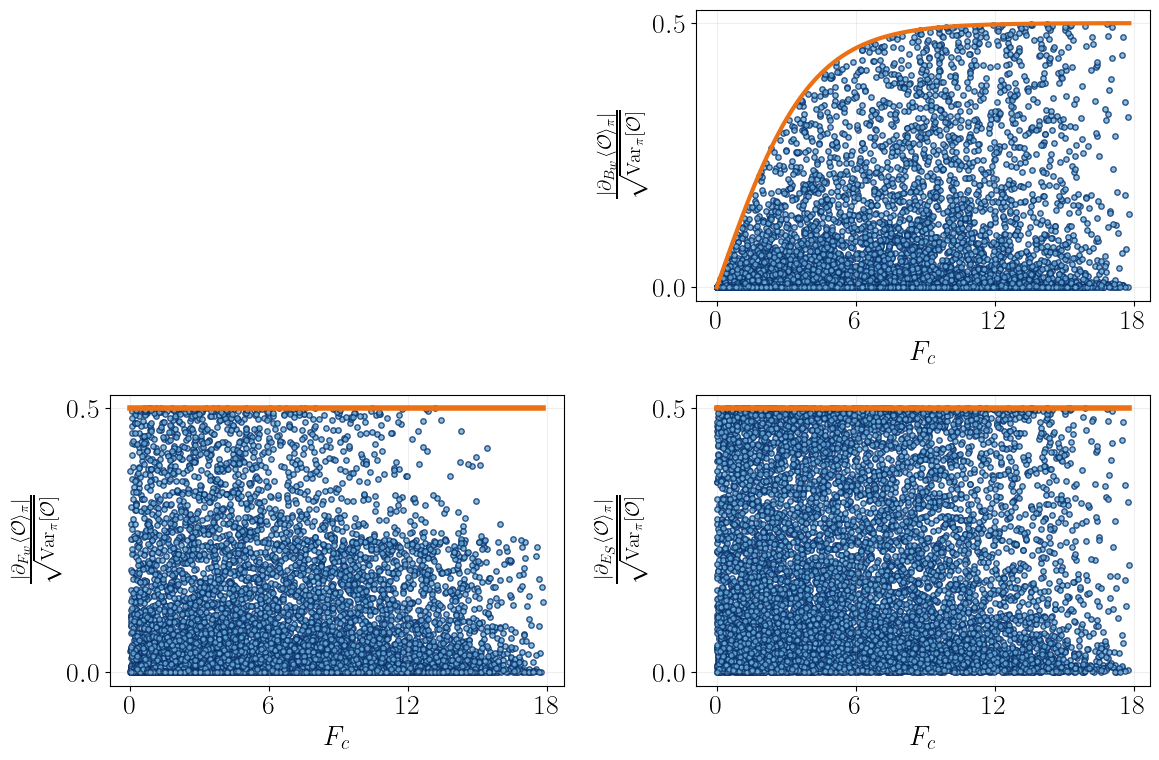

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space
plt.rcParams.update({'font.size': 20})
plt.rcParams["text.usetex"] = True

class TwoLevelSystem:
    def __init__(self, w, k, Bw, Bk, E1, E2, Fw, Fk):
        # Compute transition rates
        self.wf = w * np.exp(-Bw - E1 - Fw/2)
        self.wb = w * np.exp(-Bw - E2 + Fw/2)
        self.kf = k * np.exp(-Bk - E1 - Fk/2)
        self.kb = k * np.exp(-Bk - E2 + Fk/2)
        
        # Store parameters for perturbation calculations
        self.params = {'w': w, 'k': k, 'Bw': Bw, 'Bk': Bk, 
                      'E1': E1, 'E2': E2, 'Fw': Fw, 'Fk': Fk}
        
        # Compute steady state
        self.compute_steady_state()
        
    def compute_steady_state(self):
        """Compute steady state distribution"""
        ratio = (self.kf + self.wf) / (self.kb + self.wb)
        self.pi1 = ratio / (1 + ratio)
        self.pi2 = 1 / (1 + ratio)
        self.pi = np.array([self.pi1, self.pi2])
        
    def cycle_affinity(self):
        """Compute cycle affinity"""
        return abs(np.log((self.kf * self.wb)/(self.wf * self.kb)))
    
    def activity(self):
        """Compute total activity (sum of all fluxes)"""
        j1 = self.pi1 * self.kf - self.pi2 * self.kb  # flux through k-branch
        j2 = self.pi1 * self.wf - self.pi2 * self.wb  # flux through w-branch
        return abs(j1) + abs(j2)
    
    def compute_observable_stats(self, O):
        """Compute mean and variance of observable O"""
        mean_O = O[0] * self.pi1 + O[1] * self.pi2
        var_O = (O[0]**2 * self.pi1 + O[1]**2 * self.pi2) - mean_O**2
        return mean_O, var_O
    
    def compute_response(self, O, param):
        """Compute response of observable O with respect to parameter param"""
        eps = 1e-6  # small perturbation
        
        # Store original parameter value
        orig_value = self.params[param]
        
        # Compute original observable mean
        mean_O_orig, _ = self.compute_observable_stats(O)
        
        # Apply perturbation
        self.params[param] += eps
        
        # Recompute rates and steady state with perturbed parameter
        self.__init__(**self.params)
        
        # Compute perturbed observable mean
        mean_O_pert, _ = self.compute_observable_stats(O)
        
        # Restore original parameter
        self.params[param] = orig_value
        self.__init__(**self.params)
        
        # Return finite difference approximation of derivative
        return (mean_O_pert - mean_O_orig) / eps

def run_simulation(n_samples=40000):
    """Run multiple simulations with random parameters"""
    results = []
    
    for _ in range(n_samples):
        # Generate random parameters with exponential sampling
        w = np.exp(np.random.uniform(-9, 9))  # Range: e^-9 to e^9
        k = np.exp(np.random.uniform(-9, 9))
        Bw = np.random.uniform(-9, 0)  # Keep uniform but wider range
        Bk = np.random.uniform(-9, 0)
        E1 = np.random.uniform(-9, 0)
        E2 = np.random.uniform(-9, 0)
        Fw = np.random.uniform(-9, 9)
        Fk = np.random.uniform(-9, 9)
        
        # Generate random observable with exponential magnitude
        O = np.exp(-6*np.random.rand(3))
        # magnitude = np.exp(np.random.uniform(-9, 9))
        # O = np.random.normal(size=2)  # Random direction
        # O = O / np.linalg.norm(O) * magnitude  # Scale to random magnitude
        
        try:
            # Create system instance
            system = TwoLevelSystem(w, k, Bw, Bk, E1, E2, Fw, Fk)
            
            # Compute quantities of interest
            _, var_O = system.compute_observable_stats(O)
            activity = system.activity()
            cycle_affinity = system.cycle_affinity()
            
            # Skip if variance is too small (numerical stability)
            if var_O < 1e-10:
                continue
            
            # Compute responses (squared and normalized by variance)
            # Only normalize Bw response by tanh(F/4)
            eps = 1e-10  # Small constant to avoid division by zero
            tanh_factor = np.tanh(cycle_affinity/4)
            
            resp_Bw = (system.compute_response(O, 'Bw')**2) / (var_O)# * (tanh_factor + eps))
            resp_Fw = (system.compute_response(O, 'Fw')**2) / var_O  # No tanh normalization
            resp_E1 = (system.compute_response(O, 'E1')**2) / var_O  # No tanh normalization
            
            results.append({
                'activity': activity,
                'resp_Bw': resp_Bw,
                'resp_Fw': resp_Fw,
                'resp_E1': resp_E1,
                'affinity': cycle_affinity
            })
        except:
            continue  # Skip if any numerical issues occur
    
    return results

# Run simulation and create plots
results = run_simulation(n_samples=10000)

# Extract results
activities = np.array([r['activity'] for r in results])
affinities = np.array([r['affinity'] for r in results])
resp_Bw = np.array([r['resp_Bw'] for r in results])
resp_Fw = np.array([r['resp_Fw'] for r in results])
resp_E1 = np.array([r['resp_E1'] for r in results])

# Create plots with log scales
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(12,8))

# Make ax0 completely empty by removing all elements
ax0.remove()

for ax, resp, title, ylabel in zip(
    [ax1, ax2, ax3],
    [np.sqrt(resp_Bw), np.sqrt(resp_Fw), np.sqrt(resp_E1)],
    ['Normalized Squared Response to Bw', 'Normalized Squared Response to Fw', 'Normalized Squared Response to E1'],
    [r'$\frac{|\partial_{B_w}\langle\mathcal{O}\rangle_\pi| }{\sqrt{\mathrm{Var}_\pi[\mathcal{O}]}}$', 
     r'$\frac{|\partial_{F_w}\langle\mathcal{O}\rangle_\pi| }{\sqrt{\mathrm{Var}_\pi[\mathcal{O}]}}$', 
     r'$\frac{|\partial_{E_{S}}\langle\mathcal{O}\rangle_\pi| }{\sqrt{\mathrm{Var}_\pi[\mathcal{O}]}}$']
):
    ax.scatter(affinities, resp, edgecolors='#08306b',c='#6baed6',alpha=.8,s=15,rasterized=True)
    if ax == ax1:
        aff_ = np.linspace(np.min(affinities),np.max(affinities),100)
        ax.plot(aff_,np.tanh(aff_/4)/2,c='#ec7014',linewidth=3.0)
    else:
        ax.plot(aff_,np.ones(100)/2,c='#ec7014',linewidth=4.0)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel(r'$F_c$')
    ax.set_ylabel(ylabel)
    ax.set_yticks([0,1/2])
    ax.set_xticks([0,6,12,18])
    #ax.set_title(title)
    ax.grid(True, which="both", ls="-", alpha=0.2) 
plt.tight_layout()
plt.savefig('bound_.svg')
plt.show()